In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   RhythmScore                524164 non-null  float64
 2   AudioLoudness              524164 non-null  float64
 3   VocalContent               524164 non-null  float64
 4   AcousticQuality            524164 non-null  float64
 5   InstrumentalScore          524164 non-null  float64
 6   LivePerformanceLikelihood  524164 non-null  float64
 7   MoodScore                  524164 non-null  float64
 8   TrackDurationMs            524164 non-null  float64
 9   Energy                     524164 non-null  float64
 10  BeatsPerMinute             524164 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 44.0 MB
None


## Feature Analysis
* We have 9 different numeric features to look at, and a single feature (BeatsPerMinute) to predict
* Instead of just encoding a model off these features, let's look at the distributions and see if we can engineering some better features first

### RhythmScore Analysis
* This feature is fairly normally distributed
* But, the correlation graph doesn't appear to show an relationship, so RhythmScore is perhaps best left as a numeric feature
* We could consider encoding the outlier, but I don't think that it's big enough an there is no clear correlation

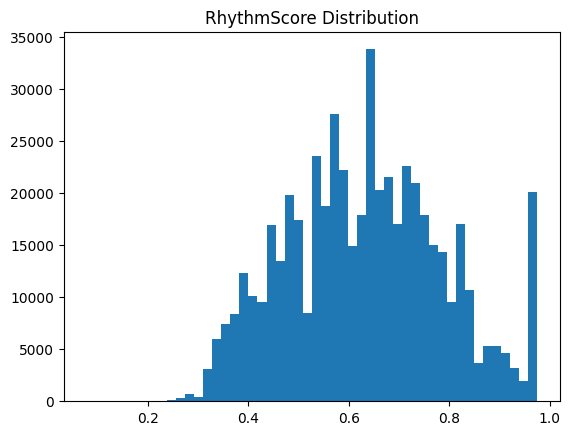

In [2]:
# This is fairly normally distributed
def plotHist(feature):
    plt.hist(df[feature], bins=50)
    plt.title(f"{feature} Distribution")
    plt.show()

plotHist("RhythmScore")

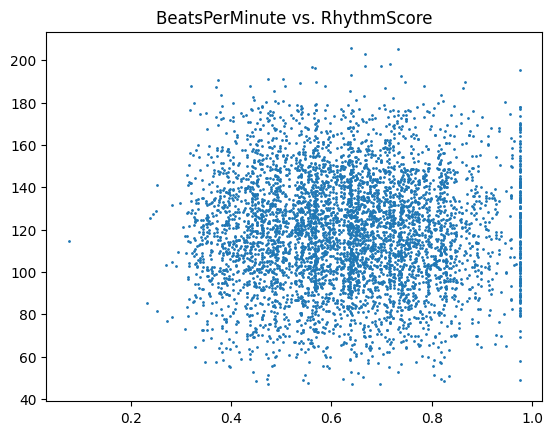

In [3]:
# The full scatter plot is too dense, sample some random indices to make it understandable
def plotPart(feature, proportion):
    indices = np.random.choice(np.arange(len(df)), size=int(len(df) * proportion), replace=False)
    plt.scatter(df[feature].iloc[indices], df["BeatsPerMinute"].iloc[indices], s=1)
    plt.title(f"BeatsPerMinute vs. {feature}")
    plt.show()

plotPart("RhythmScore", 0.01)

### AudioLoudness Analysis
* There appears to be a large outlier with a loudness score of -1.357
* Because there are more than 10% outliers in this feature, we should encode the presence of an outlier as a binary feature in our model
* Again, there doesn't appear to be an obvious correlation between these features, but we will leave it in the model


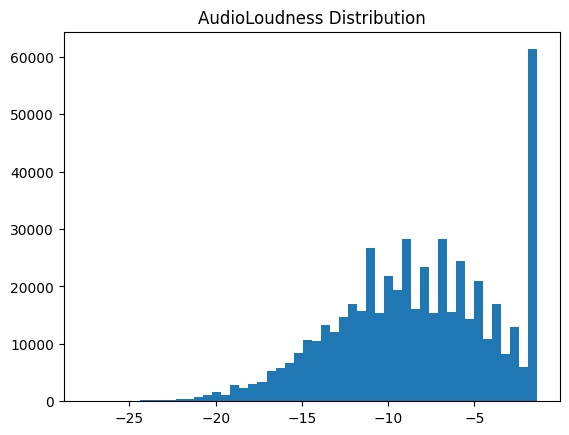

Max Loudness: -1.357
Num outliers: 57595 of 524164 entries


In [4]:
# AudioLoudness Analysis
plotHist("AudioLoudness")

max_loudness = np.max(df['AudioLoudness'])
print(f"Max Loudness: {max_loudness}")
num_outliers = np.count_nonzero(np.isclose(df["AudioLoudness"], max_loudness, atol=1e-9))
print(f"Num outliers: {num_outliers} of {len(df)} entries")

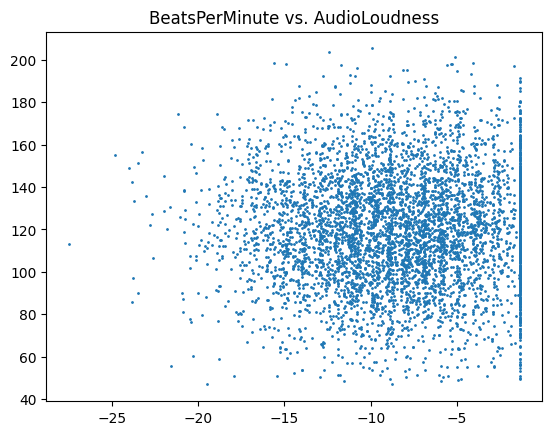

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   AudioLoudnessEncoded       524164 non-null  float64
 2   RhythmScore                524164 non-null  float64
 3   AudioLoudness              524164 non-null  float64
 4   VocalContent               524164 non-null  float64
 5   AcousticQuality            524164 non-null  float64
 6   InstrumentalScore          524164 non-null  float64
 7   LivePerformanceLikelihood  524164 non-null  float64
 8   MoodScore                  524164 non-null  float64
 9   TrackDurationMs            524164 non-null  float64
 10  Energy                     524164 non-null  float64
 11  BeatsPerMinute             524164 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 48.0 MB


In [5]:
plotPart("AudioLoudness", 0.01)
encoded_al = np.isclose(df["AudioLoudness"], max_loudness, atol=1e-6).astype(np.float64)
# df = df.drop("AudioLoudnessOutlier", axis=1)
df.insert(1, "AudioLoudnessEncoded", encoded_al)
df.info()

### VocalContent, Acoustic Quality, and InstrumentalScore Analysis
* Each of these features is heavily skewed right
* There are large outliers near or at 0, which makes me think that they really encode more binary features
* Encoding the outliers for these features is likely very helpful, and it might even be a good idea to replace the features with their binary encoding to reduce model complexity
* Our first iteration will just encode the outliers, and we can also try removing the features later

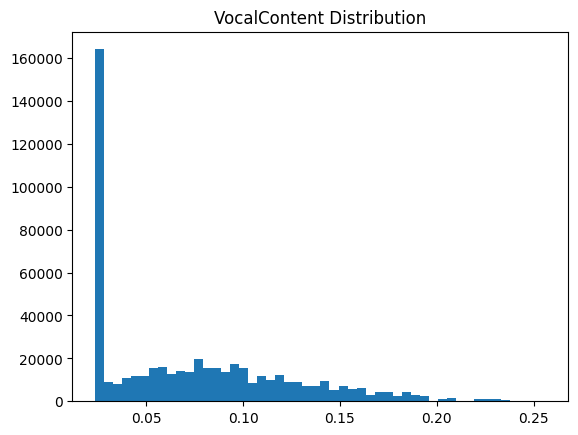

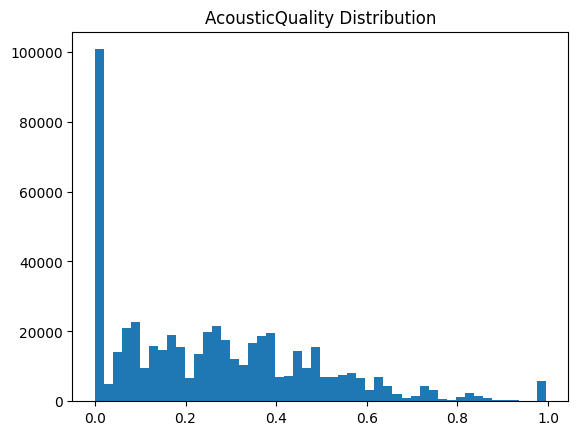

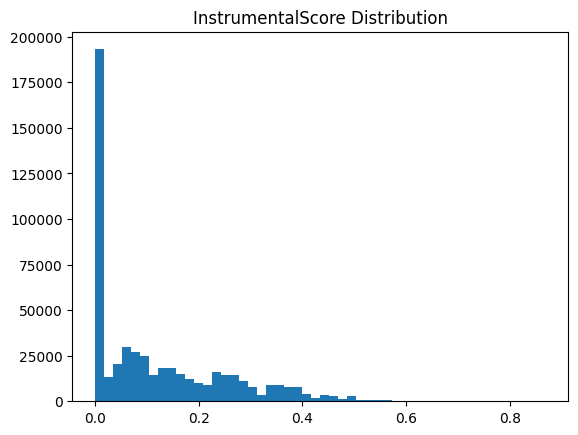

In [6]:
plotHist("VocalContent")
plotHist("AcousticQuality")
plotHist("InstrumentalScore")

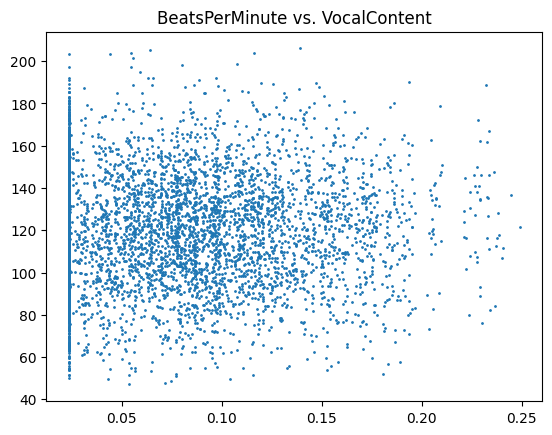

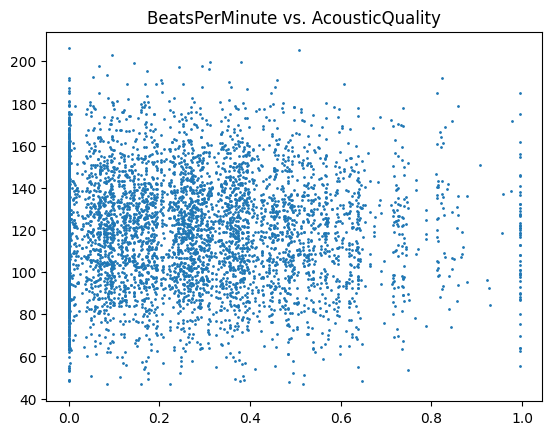

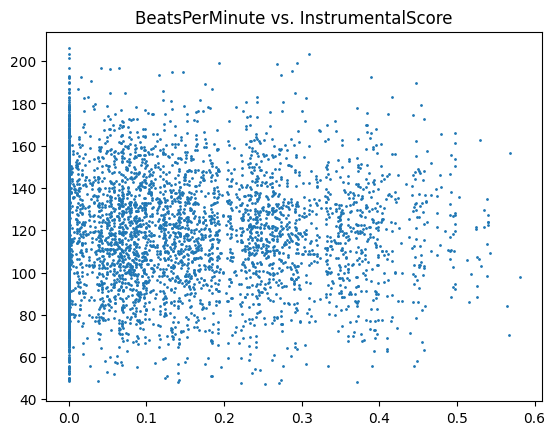

In [7]:
plotPart("VocalContent", 0.01)
plotPart("AcousticQuality", 0.01)
plotPart("InstrumentalScore", 0.01)

In [8]:
# Encoding features and adding them to the dataframe
for feature in ["VocalContent", "AcousticQuality", "InstrumentalScore"]:
    # df = df.drop(feature, axis=1)
    min_val = np.min(df[feature])
    df.insert(1, f"{feature}Encoded", np.isclose(df[feature], min_val, atol=1e-6).astype(np.float64))
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   InstrumentalScoreEncoded   524164 non-null  float64
 2   AcousticQualityEncoded     524164 non-null  float64
 3   VocalContentEncoded        524164 non-null  float64
 4   AudioLoudnessEncoded       524164 non-null  float64
 5   RhythmScore                524164 non-null  float64
 6   AudioLoudness              524164 non-null  float64
 7   VocalContent               524164 non-null  float64
 8   AcousticQuality            524164 non-null  float64
 9   InstrumentalScore          524164 non-null  float64
 10  LivePerformanceLikelihood  524164 non-null  float64
 11  MoodScore                  524164 non-null  float64
 12  TrackDurationMs            524164 non-null  float64
 13  Energy                     52

### LivePerformaceLikelihood Analysis
* This feature should also be encoded
* It has enough non-outlier values to likely be left in the final model
* It is interesting that none of the songs have a likelihood of more than 50%, considering it is a proportion

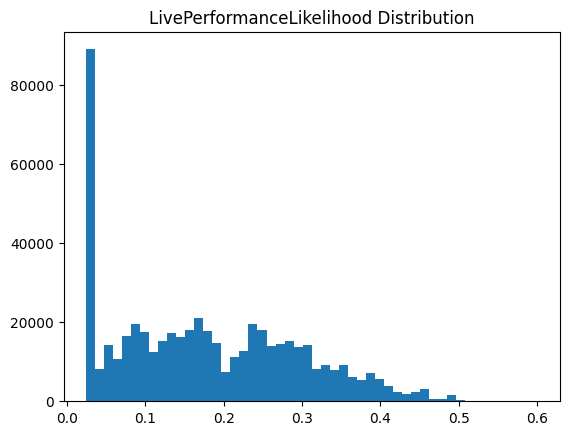

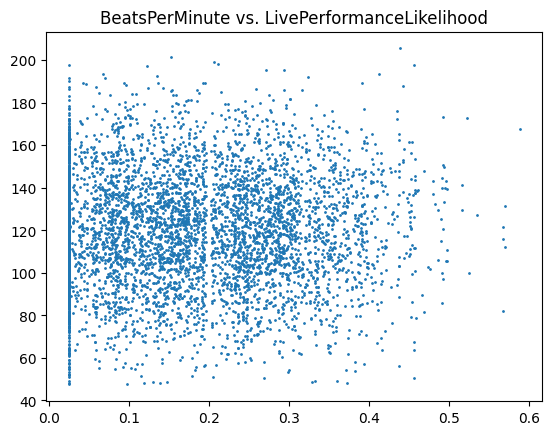

In [9]:
plotHist("LivePerformanceLikelihood")
plotPart("LivePerformanceLikelihood", 0.01)

In [10]:
label = "LivePerformanceLikelihood"
# df = df.drop(f"{label}Encoded", axis=1)
df.insert(1, f"{label}Encoded", np.isclose(df[label], np.min(df[label]), atol=1e-6).astype(np.float64))
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 16 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                524164 non-null  int64  
 1   LivePerformanceLikelihoodEncoded  524164 non-null  float64
 2   InstrumentalScoreEncoded          524164 non-null  float64
 3   AcousticQualityEncoded            524164 non-null  float64
 4   VocalContentEncoded               524164 non-null  float64
 5   AudioLoudnessEncoded              524164 non-null  float64
 6   RhythmScore                       524164 non-null  float64
 7   AudioLoudness                     524164 non-null  float64
 8   VocalContent                      524164 non-null  float64
 9   AcousticQuality                   524164 non-null  float64
 10  InstrumentalScore                 524164 non-null  float64
 11  LivePerformanceLikelihood         524164 non-null  f

### MoodScore Analysis
* Because this has both min and max outliers, we can encode both as binary variables
* The distribution between them is non-trivial and normal, so we should likely keep it in the final model
* The correlation, like all of the variables we have seen so far, has no noticible correlation

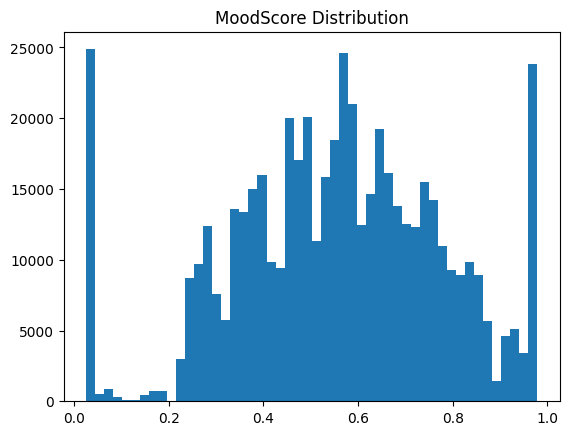

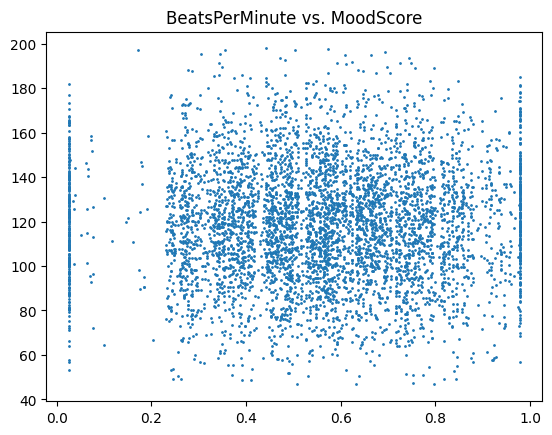

In [11]:
plotHist("MoodScore")
plotPart("MoodScore", 0.01)

In [12]:
label = "MoodScore"
max_encoded = np.isclose(df[label], np.max(df[label]), atol=1e-6).astype(np.float64)
df.insert(1, f"{label}MaxEncoded", max_encoded)
min_encoded = np.isclose(df[label], np.min(df[label]), atol=1e-6).astype(np.float64)
df.insert(1, f"{label}MinEncoded", min_encoded)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 18 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                524164 non-null  int64  
 1   MoodScoreMinEncoded               524164 non-null  float64
 2   MoodScoreMaxEncoded               524164 non-null  float64
 3   LivePerformanceLikelihoodEncoded  524164 non-null  float64
 4   InstrumentalScoreEncoded          524164 non-null  float64
 5   AcousticQualityEncoded            524164 non-null  float64
 6   VocalContentEncoded               524164 non-null  float64
 7   AudioLoudnessEncoded              524164 non-null  float64
 8   RhythmScore                       524164 non-null  float64
 9   AudioLoudness                     524164 non-null  float64
 10  VocalContent                      524164 non-null  float64
 11  AcousticQuality                   524164 non-null  f

### TrackDurationMs Analysis
* This feature is already normally distributed and without outliers
* The only interesting feature is the lack of data around 200 seconds
* Perhaps later we could interpolate data from that region, but I don't think it's necessary now
* This feature can simply be left in the training set

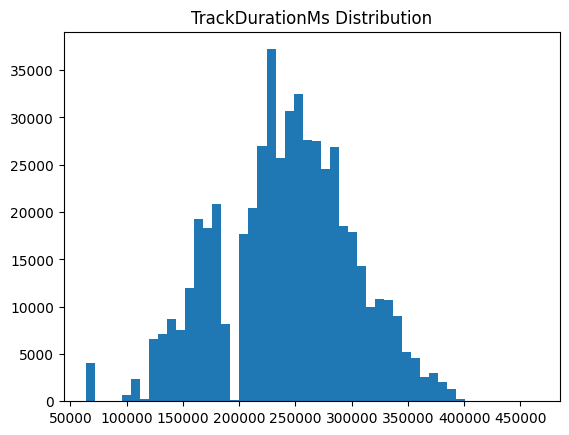

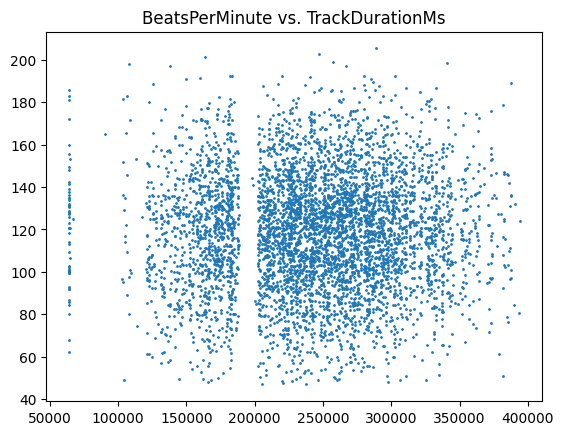

In [13]:
plotHist("TrackDurationMs")
plotPart("TrackDurationMs", 0.01)

### Energy Analysis
* This data has a relatively uniform distribution
* It should also simply be left in the final training set

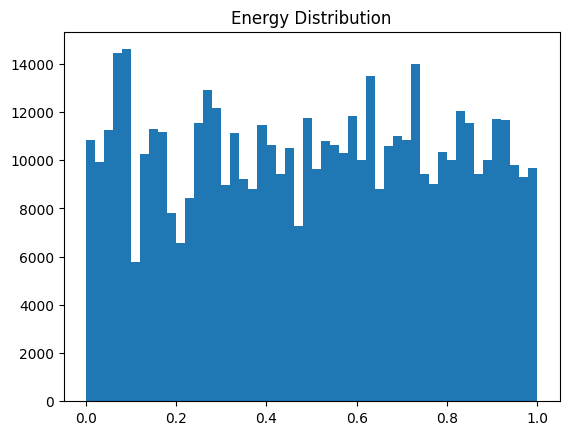

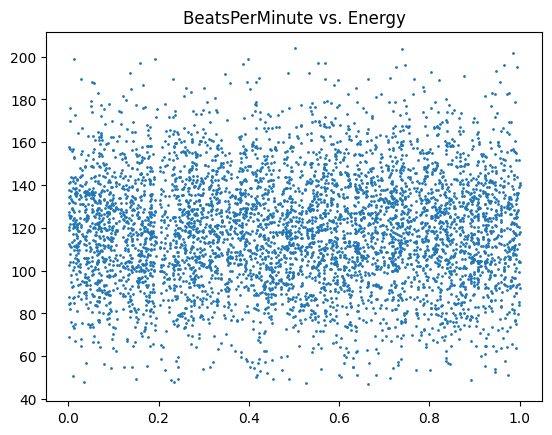

In [14]:
plotHist("Energy")
plotPart("Energy", 0.01)

In [15]:
### Normalizing Non-Categorical Features
non_categorical = ["RhythmScore", "AudioLoudness", "VocalContent",
                  "AcousticQuality", "InstrumentalScore", "LivePerformanceLikelihood",
                  "MoodScore", "TrackDurationMs", "Energy"]

for feature in non_categorical:
    normalized = (df[feature] - np.mean(df[feature])) / np.std(df[feature])
    df = df.drop(feature, axis=1)
    df.insert(1, f"{feature}Normalized", normalized)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 18 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   id                                   524164 non-null  int64  
 1   EnergyNormalized                     524164 non-null  float64
 2   TrackDurationMsNormalized            524164 non-null  float64
 3   MoodScoreNormalized                  524164 non-null  float64
 4   LivePerformanceLikelihoodNormalized  524164 non-null  float64
 5   InstrumentalScoreNormalized          524164 non-null  float64
 6   AcousticQualityNormalized            524164 non-null  float64
 7   VocalContentNormalized               524164 non-null  float64
 8   AudioLoudnessNormalized              524164 non-null  float64
 9   RhythmScoreNormalized                524164 non-null  float64
 10  MoodScoreMinEncoded                  524164 non-null  float64
 11  MoodScoreMaxE

### Correlation Anaysis with Seaborn
* Although none of the scatter plots showed much correlation, we can check with a Seaborn heatmap
* Yep! There is not much of a linear relationship between any of the variables, so a linear model will probably not work at all on this data set

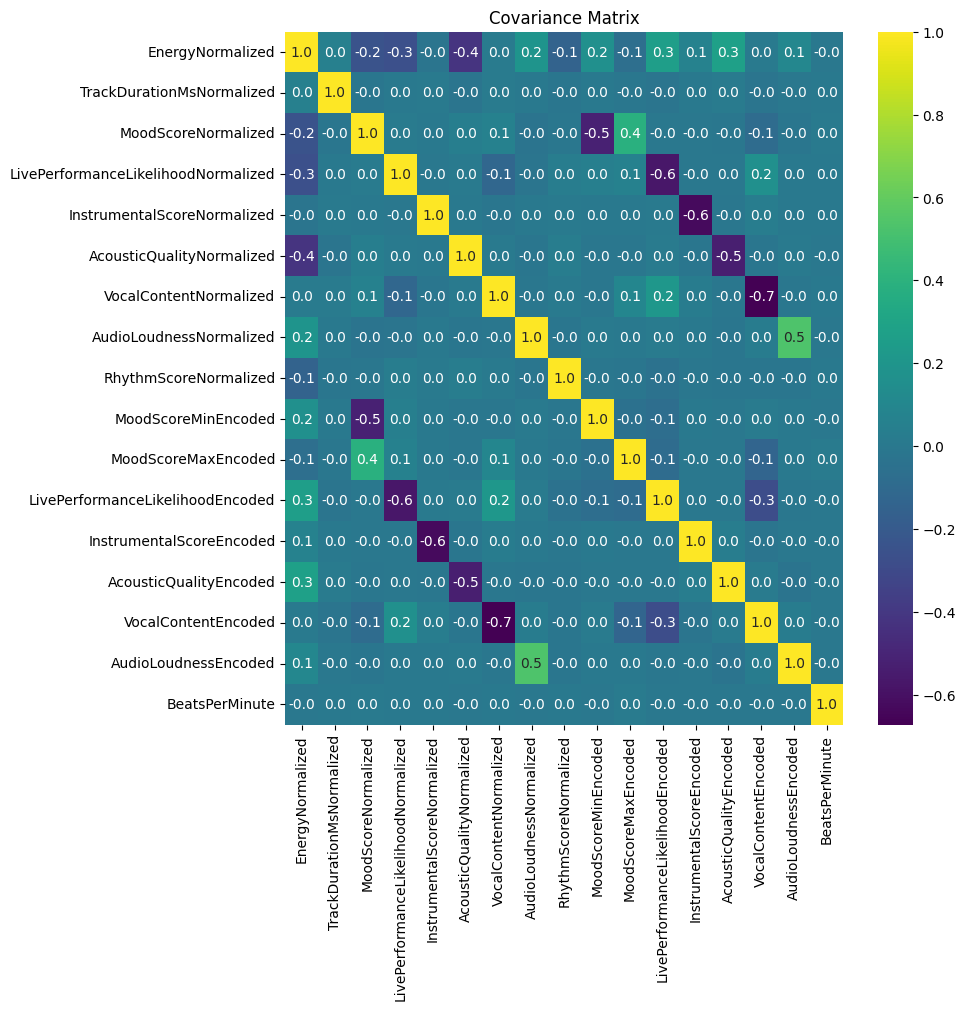

In [16]:
plt.figure(figsize=(9, 9))
cov_df = df.drop(["id"], axis=1)
sns.heatmap(cov_df.corr(), annot=True, cmap="viridis", fmt=".1f")
plt.title("Covariance Matrix")
plt.show()

## Model Selection
* We'll try 5 different non-linear regression models on the finished data set and try to predict BPM
* We'll use K-Fold Cross Validation on the data to reduce overfitting
* We also use RMSE because that's what the competition is graded based on
* This uses the default parameters at first, and we can then tune the hyperparameters of the best model
* Hopefully, one of the models works well for our data

In [17]:
from sklearn.model_selection import train_test_split

X = df.drop(["BeatsPerMinute", "id"], axis=1)
y = df["BeatsPerMinute"]
# We make the test size very large for evaulation, because we don't need the model selection results anymore
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.999, random_state=42)

In [18]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# We have 5 different models, so we can test them all and see which one has the best preliminary cv_score

In [19]:
# Testing the Support Vector Regressor
scores = []
svr = SVR()
scores.append(cross_val_score(svr, train_X, train_y, cv=5, scoring='neg_root_mean_squared_error'))
print(scores[0])

[-23.67629328 -25.01420074 -28.91813525 -28.30397317 -28.13265456]


In [20]:
# Testing the Random Forest Regressor
rfr = RandomForestRegressor()
scores.append(cross_val_score(rfr, train_X, train_y, cv=5, scoring='neg_root_mean_squared_error'))
print(scores[1])

[-25.27106506 -25.61757623 -29.85135985 -28.6628232  -28.15587276]


In [21]:
# Testing the AdaBoost Regressor
abr = AdaBoostRegressor()
scores.append(cross_val_score(abr, train_X, train_y, cv=5, scoring='neg_root_mean_squared_error'))
print(scores[2])

[-23.33847653 -25.31018956 -30.92949882 -29.49620727 -28.58628236]


In [22]:
# Testing the Extreme Gradient Boost Regressor
xgb = XGBRegressor()
scores.append(cross_val_score(xgb, train_X, train_y, cv=5, scoring='neg_root_mean_squared_error'))
print(scores[3])

[-29.29868591 -26.40989987 -30.96513753 -30.30810464 -29.55968533]


In [23]:
# Testing the K-Nearest Neighbors Regressor
knn = KNeighborsRegressor()
scores.append(cross_val_score(knn, train_X, train_y, cv=5, scoring='neg_root_mean_squared_error'))
print(scores[4])

[-25.759477   -28.96939906 -32.04820822 -29.52901444 -30.90276772]


In [24]:
# Comparing model performance
models = ["Support Vector Regression", "Random Forest Regression", 
         "AdaBoost Regressor", "XGBoost Regressor", "K-Nearest Neighbors Regressor"]

print("Average Model RMSE")
for i in range(5):
    print(f"{models[i]}: {-np.mean(scores[i])}")

Average Model RMSE
Support Vector Regression: 26.809051400742163
Random Forest Regression: 27.511739421634182
AdaBoost Regressor: 27.532130908339166
XGBoost Regressor: 29.308302655589934
K-Nearest Neighbors Regressor: 29.441773290546983


## Selecting Model
* It appears that the AdaBoost Regressor has the best RMSE overall, coming in at about 26.46
* The competition benchmark is 26.38 or so, so we should try to improve our score a little through hyperparameter tuning

## Hyperparameter Tuning
* For AdaBoost specifically, we can optimize the underlying estimator first, then feed it into AdaBoost
* This provides more opportunities for optimization, perhaps utilizing a support vector regressor because it also works very well on our data

## Results:
* It appears that a DecisionTreeRegressor is actually much faster and performs better than a SVR when input into the AdaBoost Regressor

In [25]:
svr = SVR()
adaboost = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3, splitter="random",
                                                            min_samples_split=2,
                                                            min_samples_leaf=1), n_estimators=5, learning_rate=0.1,
                            loss="linear")
score = cross_val_score(adaboost, train_X, train_y, cv=5, scoring='neg_root_mean_squared_error')
print(np.mean(score))

-26.887505332751726


## Data Modification
* I want to remove some of the more superfluous features from the model to speed up training and help eliminate noise
* Based on testing, this improves model performace by a small margin, and greatly accelerates training time

In [26]:
train_X = train_X.drop(["AcousticQualityNormalized", "LivePerformanceLikelihoodNormalized",
                       "MoodScoreNormalized"], axis=1)

In [27]:
# Optimizing the parameters of the Decision Tree Regressor first, then passing into AdaBoost
dtr = DecisionTreeRegressor()
params = {"max_depth": [1, 3, 7, 11], "splitter": ["random"], 
          "min_samples_split": [2, 4, 6],
         "min_samples_leaf": [1, 3, 5]}
grid_search_cv = GridSearchCV(dtr, params, scoring='neg_root_mean_squared_error')
grid_search_cv.fit(train_X, train_y)
print(grid_search_cv.best_params_)
print(grid_search_cv.best_score_)

"""
Best Params:
max_depth: 3
min_samples_leaf: 3
min_samples_split: 4
splitter: random
""";

{'max_depth': 1, 'min_samples_leaf': 5, 'min_samples_split': 4, 'splitter': 'random'}
-26.51542151580896


In [28]:
# Grid Search CV on the AdaBoost Model
adaboost = AdaBoostRegressor()
params = {
    "estimator": [DecisionTreeRegressor(max_depth=3, min_samples_leaf=3, min_samples_split=4, splitter="random")],
    "n_estimators": [50],
    "learning_rate": [0.1, 1, 10],
    "loss": ["linear"]
}
grid_search_cv = GridSearchCV(adaboost, params, scoring='neg_root_mean_squared_error')
grid_search_cv.fit(train_X, train_y)
print(grid_search_cv.best_params_)
print(grid_search_cv.best_score_)

"""
n_estimators: 50
learning_rate: [0.1]
loss: linear
""";

{'estimator': DecisionTreeRegressor(max_depth=3, min_samples_leaf=3, min_samples_split=4,
                      splitter='random'), 'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 50}
-26.695670468851016


In [29]:
## Training the Final Model
model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3, min_samples_leaf=3, 
                                                min_samples_split=4, splitter="random"),
                         n_estimators=50, learning_rate=0.1, loss="linear")
X = X.drop(["AcousticQualityNormalized", "LivePerformanceLikelihoodNormalized",
                       "MoodScoreNormalized"], axis=1)
model.fit(X, y)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 13 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   EnergyNormalized                  524164 non-null  float64
 1   TrackDurationMsNormalized         524164 non-null  float64
 2   InstrumentalScoreNormalized       524164 non-null  float64
 3   VocalContentNormalized            524164 non-null  float64
 4   AudioLoudnessNormalized           524164 non-null  float64
 5   RhythmScoreNormalized             524164 non-null  float64
 6   MoodScoreMinEncoded               524164 non-null  float64
 7   MoodScoreMaxEncoded               524164 non-null  float64
 8   LivePerformanceLikelihoodEncoded  524164 non-null  float64
 9   InstrumentalScoreEncoded          524164 non-null  float64
 10  AcousticQualityEncoded            524164 non-null  float64
 11  VocalContentEncoded               524164 non-null  f

## Final Data Preparation
* Now we are running the test data through the same process as the training data

In [30]:
## Preparing test df
test_df = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")

# Encoding features
max_loudness = np.max(test_df['AudioLoudness'])
encoded_al = np.isclose(test_df["AudioLoudness"], max_loudness, atol=1e-6).astype(np.float64)
test_df.insert(1, "AudioLoudnessEncoded", encoded_al)

for feature in ["VocalContent", "AcousticQuality", "InstrumentalScore"]:
    min_val = np.min(test_df[feature])
    test_df.insert(1, f"{feature}Encoded", np.isclose(test_df[feature], min_val, atol=1e-6).astype(np.float64))

label = "LivePerformanceLikelihood"
test_df.insert(1, f"{label}Encoded", np.isclose(test_df[label], np.min(test_df[label]), atol=1e-6).astype(np.float64))

label = "MoodScore"
max_encoded = np.isclose(test_df[label], np.max(test_df[label]), atol=1e-6).astype(np.float64)
test_df.insert(1, f"{label}MaxEncoded", max_encoded)
min_encoded = np.isclose(test_df[label], np.min(test_df[label]), atol=1e-6).astype(np.float64)
test_df.insert(1, f"{label}MinEncoded", min_encoded)

### Normalizing Non-Categorical Features
non_categorical = ["RhythmScore", "AudioLoudness", "VocalContent",
                  "AcousticQuality", "InstrumentalScore", "LivePerformanceLikelihood",
                  "MoodScore", "TrackDurationMs", "Energy"]

for feature in non_categorical:
    normalized = (test_df[feature] - np.mean(test_df[feature])) / np.std(test_df[feature])
    test_df = test_df.drop(feature, axis=1)
    test_df.insert(1, f"{feature}Normalized", normalized)

test_df = test_df.drop(["AcousticQualityNormalized", "LivePerformanceLikelihoodNormalized",
                       "MoodScoreNormalized"], axis=1)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174722 entries, 0 to 174721
Data columns (total 14 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                174722 non-null  int64  
 1   EnergyNormalized                  174722 non-null  float64
 2   TrackDurationMsNormalized         174722 non-null  float64
 3   InstrumentalScoreNormalized       174722 non-null  float64
 4   VocalContentNormalized            174722 non-null  float64
 5   AudioLoudnessNormalized           174722 non-null  float64
 6   RhythmScoreNormalized             174722 non-null  float64
 7   MoodScoreMinEncoded               174722 non-null  float64
 8   MoodScoreMaxEncoded               174722 non-null  float64
 9   LivePerformanceLikelihoodEncoded  174722 non-null  float64
 10  InstrumentalScoreEncoded          174722 non-null  float64
 11  AcousticQualityEncoded            174722 non-null  f

## Submitting
* We run the processed test data through the trained model and save the predicted output
* Then, check the output format and write the submission to the save file
* We're Done!!

(array([   912., 119567.,  48138.,    335.,    542.,    859.,    514.,
          1363.,   1482.,   1010.]),
 array([118.52944245, 118.9882908 , 119.44713915, 119.9059875 ,
        120.36483585, 120.8236842 , 121.28253255, 121.7413809 ,
        122.20022925, 122.6590776 , 123.11792595]),
 <BarContainer object of 10 artists>)

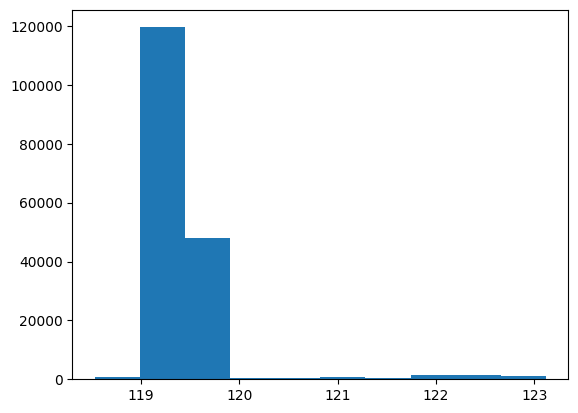

In [31]:
## Getting the prediction from the model
ids = test_df["id"]
test_df.drop("id", axis=1, inplace=True)
prediction = model.predict(test_df)
plt.hist(prediction)

In [32]:
## Submitting result
sample = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")
print(sample.info())
submission = pd.DataFrame()
submission.insert(0, "id", ids)
submission.insert(1, "BeatsPerMinute", prediction)
submission.to_csv("submission.csv", index=False)
submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174722 entries, 0 to 174721
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              174722 non-null  int64  
 1   BeatsPerMinute  174722 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.7 MB
None


,id,BeatsPerMinute
0,524164,119.420048
1,524165,119.365172
2,524166,119.594540
3,524167,119.365172
4,524168,119.397295


In [33]:
sample = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")
print(sample.info())
print(sample.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174722 entries, 0 to 174721
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              174722 non-null  int64  
 1   BeatsPerMinute  174722 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.7 MB
None
       id  BeatsPerMinute
0  524164         119.035
1  524165         119.035
2  524166         119.035
3  524167         119.035
4  524168         119.035
